# Berater Environment v13 (Orso's live)

## Changes from v12 (work in progress)
* migration to easyagents
* Max. number of steps management and debug logging migrated to easyagents.TrainingDuration
* render yields the last step, supporting modes 'ansi', 'human', 'rgb_array'
* the story of Orso

### Install gym, tensorflow, tf-agents,..., setup display

In [ ]:
!pip install -q easyagents
!pip install -q networkx==2.3.0 

##### suppress package warnings, in colab: load additional packages for rendering

In [ ]:
import sys
import warnings

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install -q pyvirtualdisplay    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

# Define Gym Environment

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpi
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import networkx as nx
import numpy as np
import random

import gym
from gym.utils import seeding
from gym import spaces


### Helper methods

In [2]:
def state_name_to_int(state):
    state_name_map = {
        'S': 0,
        'A': 1,
        'B': 2,
        'C': 3,
        'D': 4,
        'E': 5,
        'F': 6,
        'G': 7,
        'H': 8,
        'K': 9,
        'L': 10,
        'M': 11,
        'N': 12,
        'O': 13
    }
    return state_name_map[state]

def int_to_state_name(state_as_int):
    state_map = {
        0: 'S',
        1: 'A',
        2: 'B',
        3: 'C',
        4: 'D',
        5: 'E',
        6: 'F',
        7: 'G',
        8: 'H',
        9: 'K',
        10: 'L',
        11: 'M',
        12: 'N',
        13: 'O'
    }
    return state_map[state_as_int]

### Berater Environment (OpenAI Gym)

In [32]:
class BeraterEnv(gym.Env):
    """
    The Berater Problem

    Actions:
    There are 4 discrete deterministic actions, each choosing one direction
    """
    metadata = {'render.modes': ['ansi']}
    showStep = False

    def __init__(self):
        #         self.map = {
        #             'S': [('A', 100), ('B', 400), ('C', 200 )],
        #             'A': [('B', 250), ('C', 400), ('S', 100 )],
        #             'B': [('A', 250), ('C', 250), ('S', 400 )],
        #             'C': [('A', 400), ('B', 250), ('S', 200 )]
        #         }
        self.map = {
            'S': [('A', 300), ('B', 100), ('C', 200)],
            'A': [('S', 300), ('B', 100), ('E', 100), ('D', 100)],
            'B': [('S', 100), ('A', 100), ('C', 50), ('K', 200)],
            'C': [('S', 200), ('B', 50), ('M', 100), ('L', 200)],
            'D': [('A', 100), ('F', 50)],
            'E': [('A', 100), ('F', 100), ('H', 100)],
            'F': [('D', 50), ('E', 100), ('G', 200)],
            'G': [('F', 200), ('O', 300)],
            'H': [('E', 100), ('K', 300)],
            'K': [('B', 200), ('H', 300)],
            'L': [('C', 200), ('M', 50)],
            'M': [('C', 100), ('L', 50), ('N', 100)],
            'N': [('M', 100), ('O', 100)],
            'O': [('N', 100), ('G', 300)]
        }
        max_paths = 4
        self.action_space = spaces.Discrete(max_paths)

        positions = len(self.map)
        # observations: position, reward of all 4 local paths, rest reward of all locations
        # non existing path is -1000 and no position change
        # look at what #getObservation returns if you are confused
        low = np.append(np.append([0], np.full(max_paths, -1000)), np.full(positions, 0))
        high = np.append(np.append([positions - 1], np.full(max_paths, 1000)), np.full(positions, 1000))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)
        self.reward_range = (-1, 1)
        self.envEpisodeCount = 0
        self.envStepCount = 0

        self.reset()
        self.optimum = self.calculate_customers_reward()
        
#         base = "https://raw.githubusercontent.com/christianhidber/easyagents/master/images/"
        base = "../images/"
        self.image_orso = mpi.imread(base + "Bear.png")
        self.image_cave = mpi.imread(base + "Cave.png")
        self.image_honey = mpi.imread(base + "Honey.png")
        self.image_empty_pot = mpi.imread(base + "EmptyPot.png")
        self.nx_graph, self.nx_pos = self._create_nx_graph()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def iterate_path(self, state, action):
        paths = self.map[state]
        if action < len(paths):
            return paths[action]
        else:
            # sorry, no such action, stay where you are and pay a high penalty
            return (state, 1000)

    def step(self, action):
        destination, cost = self.iterate_path(self.state, action)

        self.cost = cost
        self.action=action
        self.lastStep_state = self.state
        self.state = destination
        self.customerReward = self.customer_reward[destination]
        self.reward = 0
        self.reward = (self.customerReward - self.cost) / self.optimum

        self.customer_visited(destination)
        done = (destination == 'S' and self.all_customers_visited())

        stateAsInt = state_name_to_int(self.state)
        self.totalReward += self.reward
        self.stepCount += 1
        self.envStepCount += 1

        if done and not self.isDone:
            self.envEpisodeCount += 1

        self.isDone = done
        observation = self.getObservation(stateAsInt)
        info = {"from": self.state, "to": destination}
        return observation, self.reward, done, info

    def getObservation(self, position):
        result = np.array([position,
                           self.getPathObservation(position, 0),
                           self.getPathObservation(position, 1),
                           self.getPathObservation(position, 2),
                           self.getPathObservation(position, 3)
                           ],
                          dtype=np.float32)
        all_rest_rewards = list(self.customer_reward.values())
        result = np.append(result, all_rest_rewards)
        return result

    def getPathObservation(self, position, path):
        paths = self.map[self.state]
        if path < len(paths):
            target, cost = paths[path]
            reward = self.customer_reward[target]
            result = reward - cost
        else:
            result = -1000

        return result

    def customer_visited(self, customer):
        self.customer_reward[customer] = 0

    def all_customers_visited(self):
        return self.calculate_customers_reward() == 0

    def calculate_customers_reward(self):
        sum = 0
        for value in self.customer_reward.values():
            sum += value
        return sum

    def modulate_reward(self):
        number_of_customers = len(self.map) - 1
        number_per_consultant = int(number_of_customers / 2)
        self.customer_reward = {
            'S': 0
        }
        for customer_nr in range(1, number_of_customers + 1):
            self.customer_reward[int_to_state_name(customer_nr)] = 0

        # every consultant only visits a few random customers
        samples = random.sample(range(1, number_of_customers + 1), k=number_per_consultant)
        key_list = list(self.customer_reward.keys())
        for sample in samples:
            self.customer_reward[key_list[sample]] = 1000

    def reset(self):
        self.totalReward = 0
        self.stepCount = 0
        self.isDone = False
        self.state = 'S'
        self.cost = 0
        self.action=0
        self.lastStep_state = ''
        self.customerReward = 0
        self.reward = 0
        self.envEpisodeCount += 1
        self.modulate_reward()
        return self.getObservation(state_name_to_int(self.state))
    
    def _create_nx_graph(self):
        """ generates the networkx graph representing orso's world with all its paths.
        
        :return: graph, positions
        """
        nx_graph = nx.Graph()
        for node_id in self.map.keys():
            zoom = 0.6
            image = self.image_empty_pot
            nx_graph.add_node(node_id, image=image, zoom=zoom)
        for source, connections in self.map.items():
            for target, cost in connections:
                if cost >= 300:
                    color = 'dodgerblue'
                elif cost >= 200:
                    color = 'darkgoldenrod'
                elif cost >= 100:
                    color = 'forestgreen'
                else:
                    color = 'greenyellow'
                nx_graph.add_edge(source, target, color=color, weight=6, image=self.image_cave)
        nx_pos = nx.kamada_kawai_layout(nx_graph)
        return nx_graph, nx_pos
    
    def _render_matplotlib(self):
        """ Renders the current state as a graph with matplotlib        
        """
        # draw graph using matplotlib
        result = plt.figure(1, figsize=(12,9))
        plt.clf()
        plt.subplot(111)
        ax = plt.gca()
        
        edges = self.nx_graph.edges()
        edge_colors = [self.nx_graph[u][v]['color'] for u, v in edges]
        edge_weights = [self.nx_graph[u][v]['weight'] for u, v in edges]
        nx.draw(self.nx_graph, pos=self.nx_pos,
                edges=edges, edge_color=edge_colors, width=edge_weights)

        # draw images on graph nodes
        # set image (according to the current state) and sizes (make orso's current position larger)
        for node_id in self.nx_graph.nodes():
            node = self.nx_graph.node[node_id]
            node['zoom']=0.4
            if node_id == self.state:
                node['zoom']=0.6
            node['image'] = self.image_empty_pot
            if self.customer_reward[node_id] > 0:
                node['image'] = self.image_honey
            if node_id == 'S':
                node['image'] = self.image_cave
            if self.state == node_id:
                node['image'] = self.image_orso

        # position images
        for n in self.nx_pos:
            xp, yp = self.nx_pos[n]
            offset_image = OffsetImage(self.nx_graph.node[n]['image'], self.nx_graph.node[n]['zoom'])
            offset_image.image.axes = ax
            ab = AnnotationBbox(offset_image, (xp, yp),
                                xybox=(0, 0),
                                xycoords='data',
                                boxcoords="offset points",
                                pad=0.0,
                                frameon=False
                                )
            ax.add_artist(ab)

        result.canvas.draw()
        return result
        
    def _render_ansi(self):
        result=("Episode: " + ("%4.0f  " % self.envEpisodeCount) +
                  " Step: " + ("%4.0f  " % self.stepCount) +
                  self.lastStep_state + ' --' + str(self.action) + '-> ' + self.state +
                  ' R=' + ("% 2.2f" % self.reward) + ' totalR=' + ("% 3.2f" % self.totalReward) +
                  ' cost=' + ("%4.0f" % self.cost) + ' customerR=' + ("%4.0f" % self.customerReward) + ' optimum=' + (
                              "%4.0f" % self.optimum)
                )
        return result
    
    def _render_rgb(self):
        figure = self._render_matplotlib()
        figure.canvas.draw()
        buf = figure.canvas.tostring_rgb()
        num_cols, num_rows = figure.canvas.get_width_height()
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        plt.clf()
        return result

    def render(self, mode='human'):
        if mode == 'ansi':
            return self._render_ansi()
        elif mode == 'human':
            self._render_matplotlib()
            plt.show()
            return
        elif mode == 'rgb_array':
            return self._render_rgb()
        else:
            super().render(mode=mode)
            

# First Steps
A way to view the visualization: 

Orso - the bear - lives in his cave (position 'S'). Orso knows his area and where he can 
typically find some honey (positions 'A' to 'O'). The honey places are scattered all over his home turf and connected
by some pathways. Some connections are easy like walking over a grassy field (light green, very low cost) or forests 
(dark green, low cost), a bit strenuous like walking over a hill (brown, higher costs) and very arduous like swimming 
through a lake (blue, very high costs).

There are other bears around competing for the honey pots. So some spots have honey (yellow nodes) and some
are already taken (brown nodes).

Every morning, Orso awakes and starts looking for some honey. But every day, the honey pots are at a new place
( env.reset() ). So Orso climbs a tree near his cave to find out where the honey is. Even with this knowledge it is not clear which route he should take. Being a bear also means being lazy, so Orso wants to get as much honey as possible while at the lowest costs possible. At each spot he has to decide where to go next (the action). His daily journey ends when his back in his own cave.

Be god and create Orso's world:

In [33]:
b = BeraterEnv()

A new morning starts (rerun the cell below to see how the honey pots change places). But Orso 
(depicted in 'fuchsia', Marsha's favorite color ?) doesn't know 
about the sweetness of honey or his surroundings. So the climbs a tree to get an overview and this is what he sees:

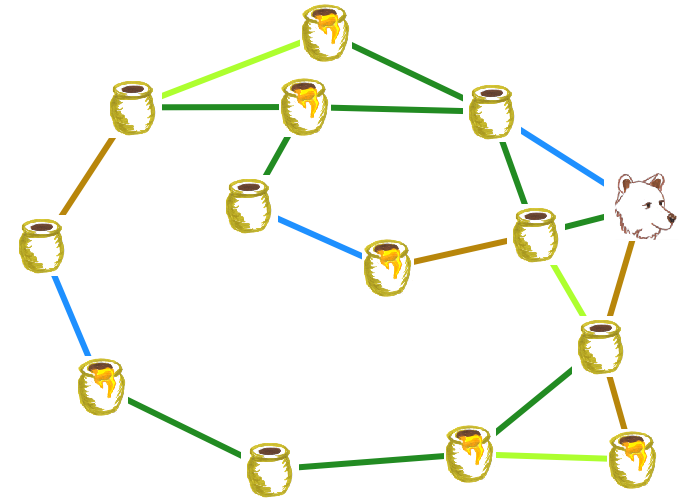

In [34]:
b.reset()
b.render() 

Take Orso by his paws and go for a few steps:

Episode:    2   Step:    1  S --1-> B R=-0.02 totalR=-0.02 cost= 100 customerR=   0 optimum=6000


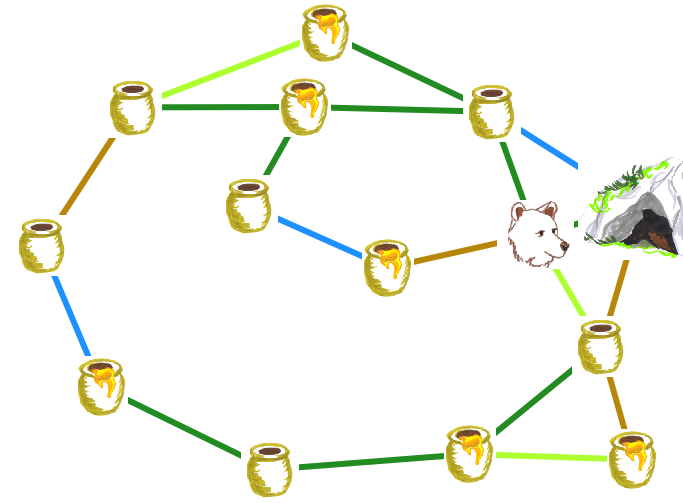

In [35]:
b.step(1)
print(b.render(mode='ansi'))
b.render()


Note that the honey pot nodes turn brown once Orso has passed and taken the honey.

Episode:    2   Step:    2  B --3-> K R= 0.13 totalR= 0.12 cost= 200 customerR=1000 optimum=6000


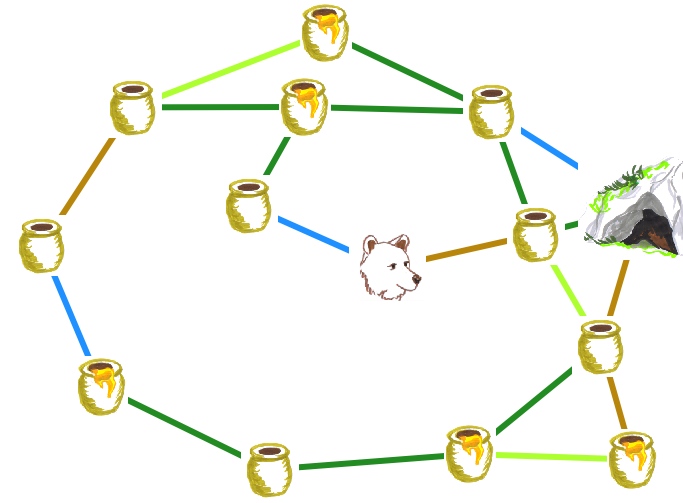

In [36]:
b.step(3)
print(b.render(mode='ansi'))
b.render()

Episode:    2   Step:    3  K --1-> H R=-0.05 totalR= 0.07 cost= 300 customerR=   0 optimum=6000


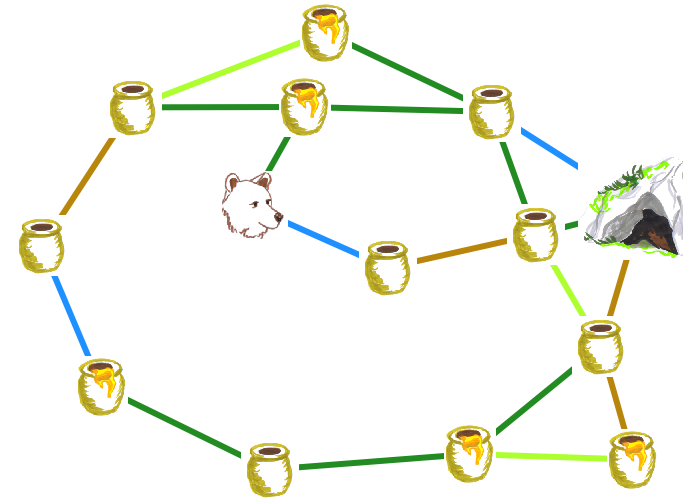

In [37]:
b.step(1)
print(b.render(mode='ansi'))
b.render()

Now Orso must start to learn by himself to take actions to gather all the honey while minimizing the effort:

# Train policy with tfagents PpoAgent

### Register with OpenAI Gym

In [38]:
if not 'isEnvRegistered' in locals():
  env_name="Berater-v1"
  gym.envs.registration.register(id=env_name,entry_point=BeraterEnv,max_episode_steps=1000)
  isEnvRegistered=True
  print("Berater registered as '" + env_name + "'")
else:
  print("Already registered")

Berater registered as 'Berater-v1'


##  Dry run (short training, no logging)

In [39]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDurationFast
from easyagents.config import LoggingSilent

In [40]:
import tensorflow as tf

In [41]:
ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',                        
                        training_duration=TrainingDurationFast(max_steps_per_episode = 50),
                        logging=LoggingSilent())
ppoAgent.train()

W0723 16:29:05.941767 16748 deprecation.py:323] From C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\tensorflow\python\ops\math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Visualize training performance

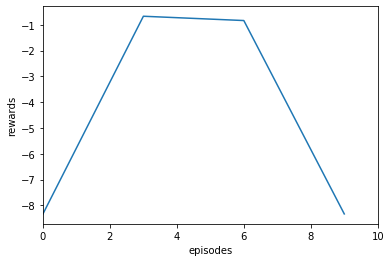

In [42]:
ppoAgent.plot_average_rewards()

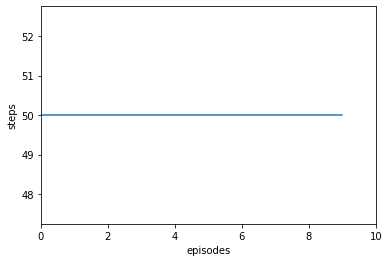

In [43]:
ppoAgent.plot_average_steps()

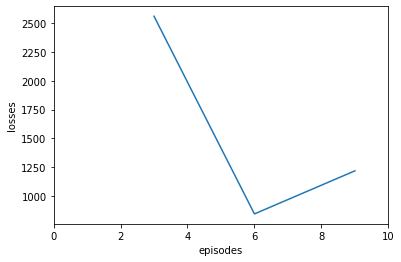

In [44]:
ppoAgent.plot_losses()

## Some training & logging (default, on custom network)

In [45]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [46]:
ppoAgent = PpoAgent( gym_env_name = 'Berater-v1', fc_layers=(500,500,500), 
                     training_duration=TrainingDuration(max_steps_per_episode = 50) )
ppoAgent.train()

I0723 16:29:09.498400 16748 agents.py:92] PpoAgent on Berater-v1 [fc_layers=(500, 500, 500), learning_rate=0.001]
I0723 16:29:09.500395 16748 agents.py:92] TrainingDuration 250=25*10 episodes [max 50 steps/episode, 5 epochs/iteration, policy eval every 50=5*10 episodes]
I0723 16:29:13.452234 16748 agents.py:92] current policy       : avg_reward=-0.785, avg_steps=50.000
I0723 16:29:19.745056 16748 agents.py:92] training    1 of 25  : completed tf_agent.train(...) =  603.592 [loss]
I0723 16:29:23.871022 16748 agents.py:92] training    2 of 25  : completed tf_agent.train(...) =  843.534 [loss]
I0723 16:29:28.582358 16748 agents.py:92] training    3 of 25  : completed tf_agent.train(...) =  278.186 [loss]
I0723 16:29:30.924633 16748 agents.py:92] training    4 of 25  : completed tf_agent.train(...) =  328.207 [loss]
I0723 16:29:32.108671 16748 agents.py:92] training    5 of 25  : completed tf_agent.train(...) =  242.078 [loss]
I0723 16:29:34.667995 16748 agents.py:92] current policy       

### Visualize

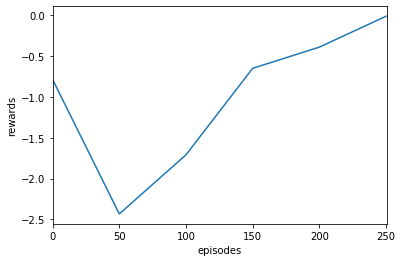

In [47]:
ppoAgent.plot_average_rewards()

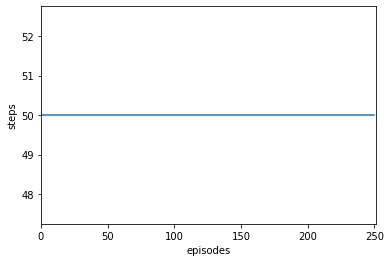

In [48]:
ppoAgent.plot_average_steps()

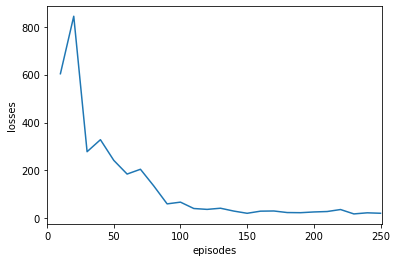

In [49]:
ppoAgent.plot_losses()

In [50]:
ppoAgent.render_episodes(num_episodes=1,mode='ansi')

Episode:   62   Step:    0   --0-> S R= 0.00 totalR= 0.00 cost=   0 customerR=   0 optimum=6000
Episode:   62   Step:    1  S --1-> B R= 0.15 totalR= 0.15 cost= 100 customerR=1000 optimum=6000
Episode:   62   Step:    2  B --2-> C R= 0.16 totalR= 0.31 cost=  50 customerR=1000 optimum=6000
Episode:   62   Step:    3  C --1-> B R=-0.01 totalR= 0.30 cost=  50 customerR=   0 optimum=6000
Episode:   62   Step:    4  B --1-> A R=-0.02 totalR= 0.28 cost= 100 customerR=   0 optimum=6000
Episode:   62   Step:    5  A --2-> E R= 0.15 totalR= 0.43 cost= 100 customerR=1000 optimum=6000
Episode:   62   Step:    6  E --1-> F R=-0.02 totalR= 0.42 cost= 100 customerR=   0 optimum=6000
Episode:   62   Step:    7  F --2-> G R= 0.13 totalR= 0.55 cost= 200 customerR=1000 optimum=6000
Episode:   62   Step:    8  G --1-> O R= 0.12 totalR= 0.67 cost= 300 customerR=1000 optimum=6000
Episode:   62   Step:    9  O --0-> N R=-0.02 totalR= 0.65 cost= 100 customerR=   0 optimum=6000
Episode:   62   Step:   10  N -

In [51]:
from IPython.display import HTML

HTML( ppoAgent.render_episodes_to_html(num_episodes=1, fps=1) )

C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\ipykernel_launcher.py:250: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
W0723 16:30:17.115565 16748 ffmpeg.py:839] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (648, 864) to (656, 864) to ensure video compatibility with most codecs and players. To prevent resizing, make you

<Figure size 864x648 with 0 Axes>

## Custom training (duration, learning rate)

In [52]:
from easyagents.tfagents import PpoAgent
from easyagents.config import TrainingDuration

In [53]:
training_duration=TrainingDuration( num_iterations = 2500,
                                    num_episodes_per_iteration = 10,
                                    max_steps_per_episode = 50,
                                    num_epochs_per_iteration = 5 )

In [54]:
%%time

ppoAgent = PpoAgent(    gym_env_name = 'Berater-v1',
                        fc_layers=(500,500,500), 
                        training_duration=training_duration,
                        learning_rate=1e-4
                   )
ppoAgent.train()

I0723 16:30:21.990127 16748 agents.py:92] PpoAgent on Berater-v1 [fc_layers=(500, 500, 500), learning_rate=0.0001]
I0723 16:30:21.991117 16748 agents.py:92] TrainingDuration 25000=2500*10 episodes [max 50 steps/episode, 5 epochs/iteration, policy eval every 50=5*10 episodes]
I0723 16:30:24.803159 16748 agents.py:92] current policy       : avg_reward=-0.661, avg_steps=50.000
I0723 16:30:31.024533 16748 agents.py:92] training    1 of 2500: completed tf_agent.train(...) =  812.526 [loss]
I0723 16:30:34.714173 16748 agents.py:92] training    2 of 2500: completed tf_agent.train(...) = 1117.115 [loss]
I0723 16:30:39.219149 16748 agents.py:92] training    3 of 2500: completed tf_agent.train(...) = 1041.235 [loss]
I0723 16:30:40.293276 16748 agents.py:92] training    4 of 2500: completed tf_agent.train(...) = 1147.899 [loss]
I0723 16:30:42.183242 16748 agents.py:92] training    5 of 2500: completed tf_agent.train(...) =  789.060 [loss]
I0723 16:30:44.676429 16748 agents.py:92] current policy  

I0723 16:32:49.803299 16748 agents.py:92] current policy       : avg_reward=-0.446, avg_steps=50.000
I0723 16:32:51.798973 16748 agents.py:92] training   61 of 2500: completed tf_agent.train(...) =   25.663 [loss]
I0723 16:32:53.909830 16748 agents.py:92] training   62 of 2500: completed tf_agent.train(...) =   27.423 [loss]
I0723 16:32:55.999237 16748 agents.py:92] training   63 of 2500: completed tf_agent.train(...) =   24.981 [loss]
I0723 16:32:57.933065 16748 agents.py:92] training   64 of 2500: completed tf_agent.train(...) =   33.178 [loss]
I0723 16:32:59.952665 16748 agents.py:92] training   65 of 2500: completed tf_agent.train(...) =   20.973 [loss]
I0723 16:33:02.179094 16748 agents.py:92] current policy       : avg_reward=0.111, avg_steps=39.300
I0723 16:33:03.058742 16748 agents.py:92] training   66 of 2500: completed tf_agent.train(...) =   22.411 [loss]
I0723 16:33:06.009387 16748 agents.py:92] training   67 of 2500: completed tf_agent.train(...) =   20.059 [loss]
I0723 16

I0723 16:35:03.620162 16748 agents.py:92] training  122 of 2500: completed tf_agent.train(...) =   10.415 [loss]
I0723 16:35:04.438987 16748 agents.py:92] training  123 of 2500: completed tf_agent.train(...) =   18.724 [loss]
I0723 16:35:06.438122 16748 agents.py:92] training  124 of 2500: completed tf_agent.train(...) =   10.549 [loss]
I0723 16:35:07.247955 16748 agents.py:92] training  125 of 2500: completed tf_agent.train(...) =   11.321 [loss]
I0723 16:35:11.562570 16748 agents.py:92] current policy       : avg_reward=-0.425, avg_steps=50.000
I0723 16:35:12.306581 16748 agents.py:92] training  126 of 2500: completed tf_agent.train(...) =   12.446 [loss]
I0723 16:35:14.709159 16748 agents.py:92] training  127 of 2500: completed tf_agent.train(...) =   12.618 [loss]
I0723 16:35:16.676230 16748 agents.py:92] training  128 of 2500: completed tf_agent.train(...) =    9.554 [loss]
I0723 16:35:17.433206 16748 agents.py:92] training  129 of 2500: completed tf_agent.train(...) =    8.855 [l

I0723 16:36:52.171929 16748 agents.py:92] training  184 of 2500: completed tf_agent.train(...) =    9.555 [loss]
I0723 16:36:53.682013 16748 agents.py:92] training  185 of 2500: completed tf_agent.train(...) =   15.766 [loss]
I0723 16:36:55.682220 16748 agents.py:92] current policy       : avg_reward=0.032, avg_steps=38.600
I0723 16:36:56.179890 16748 agents.py:92] training  186 of 2500: completed tf_agent.train(...) =   13.767 [loss]
I0723 16:36:57.731528 16748 agents.py:92] training  187 of 2500: completed tf_agent.train(...) =    5.592 [loss]
I0723 16:36:59.109842 16748 agents.py:92] training  188 of 2500: completed tf_agent.train(...) =    4.619 [loss]
I0723 16:37:00.743325 16748 agents.py:92] training  189 of 2500: completed tf_agent.train(...) =    9.825 [loss]
I0723 16:37:01.193123 16748 agents.py:92] training  190 of 2500: completed tf_agent.train(...) =    4.524 [loss]
I0723 16:37:02.897062 16748 agents.py:92] current policy       : avg_reward=0.302, avg_steps=32.800
I0723 16:

I0723 16:38:23.687640 16748 agents.py:92] current policy       : avg_reward=0.267, avg_steps=25.900
I0723 16:38:25.157339 16748 agents.py:92] training  246 of 2500: completed tf_agent.train(...) =    5.522 [loss]
I0723 16:38:26.865927 16748 agents.py:92] training  247 of 2500: completed tf_agent.train(...) =   28.852 [loss]
I0723 16:38:28.329035 16748 agents.py:92] training  248 of 2500: completed tf_agent.train(...) =    3.037 [loss]
I0723 16:38:29.889871 16748 agents.py:92] training  249 of 2500: completed tf_agent.train(...) =    4.597 [loss]
I0723 16:38:30.448389 16748 agents.py:92] training  250 of 2500: completed tf_agent.train(...) =   18.141 [loss]
I0723 16:38:32.339331 16748 agents.py:92] current policy       : avg_reward=0.233, avg_steps=32.200
I0723 16:38:33.890183 16748 agents.py:92] training  251 of 2500: completed tf_agent.train(...) =    4.312 [loss]
I0723 16:38:34.529473 16748 agents.py:92] training  252 of 2500: completed tf_agent.train(...) =   26.252 [loss]
I0723 16:

I0723 16:39:42.442022 16748 agents.py:92] training  307 of 2500: completed tf_agent.train(...) =    2.394 [loss]
I0723 16:39:43.943128 16748 agents.py:92] training  308 of 2500: completed tf_agent.train(...) =    4.822 [loss]
I0723 16:39:44.265266 16748 agents.py:92] training  309 of 2500: completed tf_agent.train(...) =    2.197 [loss]
I0723 16:39:45.757584 16748 agents.py:92] training  310 of 2500: completed tf_agent.train(...) =    9.826 [loss]
I0723 16:39:46.856634 16748 agents.py:92] current policy       : avg_reward=0.522, avg_steps=20.700
I0723 16:39:47.362280 16748 agents.py:92] training  311 of 2500: completed tf_agent.train(...) =   10.850 [loss]
I0723 16:39:48.807429 16748 agents.py:92] training  312 of 2500: completed tf_agent.train(...) =    4.094 [loss]
I0723 16:39:50.160714 16748 agents.py:92] training  313 of 2500: completed tf_agent.train(...) =    3.217 [loss]
I0723 16:39:51.627830 16748 agents.py:92] training  314 of 2500: completed tf_agent.train(...) =   30.419 [lo

I0723 16:40:45.129387 16748 agents.py:92] training  369 of 2500: completed tf_agent.train(...) =    1.770 [loss]
I0723 16:40:45.827502 16748 agents.py:92] training  370 of 2500: completed tf_agent.train(...) =   14.623 [loss]
I0723 16:40:47.277623 16748 agents.py:92] current policy       : avg_reward=0.518, avg_steps=20.800
I0723 16:40:47.714455 16748 agents.py:92] training  371 of 2500: completed tf_agent.train(...) =    1.357 [loss]
I0723 16:40:48.182205 16748 agents.py:92] training  372 of 2500: completed tf_agent.train(...) =    1.403 [loss]
I0723 16:40:48.583133 16748 agents.py:92] training  373 of 2500: completed tf_agent.train(...) =    1.443 [loss]
I0723 16:40:48.923222 16748 agents.py:92] training  374 of 2500: completed tf_agent.train(...) =    1.014 [loss]
I0723 16:40:50.564953 16748 agents.py:92] training  375 of 2500: completed tf_agent.train(...) =    2.335 [loss]
I0723 16:40:51.890911 16748 agents.py:92] current policy       : avg_reward=0.457, avg_steps=22.000
I0723 16:

I0723 16:41:34.200266 16748 agents.py:92] current policy       : avg_reward=0.511, avg_steps=21.100
I0723 16:41:34.539359 16748 agents.py:92] training  431 of 2500: completed tf_agent.train(...) =    1.802 [loss]
I0723 16:41:35.984643 16748 agents.py:92] training  432 of 2500: completed tf_agent.train(...) =    2.024 [loss]
I0723 16:41:36.322741 16748 agents.py:92] training  433 of 2500: completed tf_agent.train(...) =    1.972 [loss]
I0723 16:41:36.705715 16748 agents.py:92] training  434 of 2500: completed tf_agent.train(...) =    6.867 [loss]
I0723 16:41:37.039822 16748 agents.py:92] training  435 of 2500: completed tf_agent.train(...) =    0.965 [loss]
I0723 16:41:37.747998 16748 agents.py:92] current policy       : avg_reward=0.687, avg_steps=12.500
I0723 16:41:38.153912 16748 agents.py:92] training  436 of 2500: completed tf_agent.train(...) =    6.346 [loss]
I0723 16:41:38.562820 16748 agents.py:92] training  437 of 2500: completed tf_agent.train(...) =    4.245 [loss]
I0723 16:

I0723 16:42:11.788317 16748 agents.py:92] training  492 of 2500: completed tf_agent.train(...) =   11.204 [loss]
I0723 16:42:12.146366 16748 agents.py:92] training  493 of 2500: completed tf_agent.train(...) =    1.059 [loss]
I0723 16:42:12.508392 16748 agents.py:92] training  494 of 2500: completed tf_agent.train(...) =    1.007 [loss]
I0723 16:42:12.862446 16748 agents.py:92] training  495 of 2500: completed tf_agent.train(...) =    2.162 [loss]
I0723 16:42:13.649357 16748 agents.py:92] current policy       : avg_reward=0.685, avg_steps=13.100
I0723 16:42:13.976482 16748 agents.py:92] training  496 of 2500: completed tf_agent.train(...) =    1.221 [loss]
I0723 16:42:14.302642 16748 agents.py:92] training  497 of 2500: completed tf_agent.train(...) =    0.767 [loss]
I0723 16:42:14.707527 16748 agents.py:92] training  498 of 2500: completed tf_agent.train(...) =    1.202 [loss]
I0723 16:42:15.043629 16748 agents.py:92] training  499 of 2500: completed tf_agent.train(...) =    1.361 [lo

I0723 16:43:03.789811 16748 agents.py:92] training  554 of 2500: completed tf_agent.train(...) =    0.643 [loss]
I0723 16:43:04.231146 16748 agents.py:92] training  555 of 2500: completed tf_agent.train(...) =    2.991 [loss]
I0723 16:43:05.506748 16748 agents.py:92] current policy       : avg_reward=0.573, avg_steps=20.800
I0723 16:43:05.824897 16748 agents.py:92] training  556 of 2500: completed tf_agent.train(...) =    0.893 [loss]
I0723 16:43:06.160001 16748 agents.py:92] training  557 of 2500: completed tf_agent.train(...) =    0.557 [loss]
I0723 16:43:06.465186 16748 agents.py:92] training  558 of 2500: completed tf_agent.train(...) =    1.102 [loss]
I0723 16:43:06.862124 16748 agents.py:92] training  559 of 2500: completed tf_agent.train(...) =   29.262 [loss]
I0723 16:43:07.187253 16748 agents.py:92] training  560 of 2500: completed tf_agent.train(...) =    1.711 [loss]
I0723 16:43:08.173616 16748 agents.py:92] current policy       : avg_reward=0.629, avg_steps=17.800
I0723 16:

I0723 16:43:44.493460 16748 agents.py:92] current policy       : avg_reward=0.718, avg_steps=13.400
I0723 16:43:45.807945 16748 agents.py:92] training  616 of 2500: completed tf_agent.train(...) =    0.704 [loss]
I0723 16:43:46.185935 16748 agents.py:92] training  617 of 2500: completed tf_agent.train(...) =    3.787 [loss]
I0723 16:43:46.713640 16748 agents.py:92] training  618 of 2500: completed tf_agent.train(...) =    0.992 [loss]
I0723 16:43:47.264168 16748 agents.py:92] training  619 of 2500: completed tf_agent.train(...) =   56.150 [loss]
I0723 16:43:47.674073 16748 agents.py:92] training  620 of 2500: completed tf_agent.train(...) =    1.990 [loss]
I0723 16:43:48.439025 16748 agents.py:92] current policy       : avg_reward=0.689, avg_steps=14.000
I0723 16:43:48.790479 16748 agents.py:92] training  621 of 2500: completed tf_agent.train(...) =    2.544 [loss]
I0723 16:43:49.116214 16748 agents.py:92] training  622 of 2500: completed tf_agent.train(...) =    3.638 [loss]
I0723 16:

I0723 16:44:24.709451 16748 agents.py:92] training  677 of 2500: completed tf_agent.train(...) =    1.103 [loss]
I0723 16:44:25.070486 16748 agents.py:92] training  678 of 2500: completed tf_agent.train(...) =    1.763 [loss]
I0723 16:44:25.376667 16748 agents.py:92] training  679 of 2500: completed tf_agent.train(...) =    0.465 [loss]
I0723 16:44:25.699804 16748 agents.py:92] training  680 of 2500: completed tf_agent.train(...) =    0.763 [loss]
I0723 16:44:26.729050 16748 agents.py:92] current policy       : avg_reward=0.569, avg_steps=17.100
I0723 16:44:27.056176 16748 agents.py:92] training  681 of 2500: completed tf_agent.train(...) =    0.518 [loss]
I0723 16:44:27.387291 16748 agents.py:92] training  682 of 2500: completed tf_agent.train(...) =    1.553 [loss]
I0723 16:44:27.796199 16748 agents.py:92] training  683 of 2500: completed tf_agent.train(...) =   31.549 [loss]
I0723 16:44:28.184162 16748 agents.py:92] training  684 of 2500: completed tf_agent.train(...) =    0.817 [lo

I0723 16:44:58.817365 16748 agents.py:92] training  739 of 2500: completed tf_agent.train(...) =    0.561 [loss]
I0723 16:44:59.132523 16748 agents.py:92] training  740 of 2500: completed tf_agent.train(...) =    0.594 [loss]
I0723 16:44:59.944367 16748 agents.py:92] current policy       : avg_reward=0.697, avg_steps=13.800
I0723 16:45:00.285814 16748 agents.py:92] training  741 of 2500: completed tf_agent.train(...) =    1.077 [loss]
I0723 16:45:00.751568 16748 agents.py:92] training  742 of 2500: completed tf_agent.train(...) =  118.340 [loss]
I0723 16:45:01.079691 16748 agents.py:92] training  743 of 2500: completed tf_agent.train(...) =    2.690 [loss]
I0723 16:45:01.432746 16748 agents.py:92] training  744 of 2500: completed tf_agent.train(...) =    3.450 [loss]
I0723 16:45:01.782811 16748 agents.py:92] training  745 of 2500: completed tf_agent.train(...) =    5.859 [loss]
I0723 16:45:02.910749 16748 agents.py:92] current policy       : avg_reward=0.690, avg_steps=14.000
I0723 16:

I0723 16:45:37.991523 16748 agents.py:92] current policy       : avg_reward=0.651, avg_steps=17.900
I0723 16:45:38.302726 16748 agents.py:92] training  801 of 2500: completed tf_agent.train(...) =    0.978 [loss]
I0723 16:45:38.654748 16748 agents.py:92] training  802 of 2500: completed tf_agent.train(...) =    0.719 [loss]
I0723 16:45:39.013791 16748 agents.py:92] training  803 of 2500: completed tf_agent.train(...) =    0.600 [loss]
I0723 16:45:39.429677 16748 agents.py:92] training  804 of 2500: completed tf_agent.train(...) =    0.608 [loss]
I0723 16:45:39.805670 16748 agents.py:92] training  805 of 2500: completed tf_agent.train(...) =    1.117 [loss]
I0723 16:45:40.621488 16748 agents.py:92] current policy       : avg_reward=0.702, avg_steps=12.900
I0723 16:45:40.959584 16748 agents.py:92] training  806 of 2500: completed tf_agent.train(...) =    3.260 [loss]
I0723 16:45:41.270754 16748 agents.py:92] training  807 of 2500: completed tf_agent.train(...) =    0.545 [loss]
I0723 16:

I0723 16:46:13.533344 16748 agents.py:92] training  862 of 2500: completed tf_agent.train(...) =    0.924 [loss]
I0723 16:46:14.027052 16748 agents.py:92] training  863 of 2500: completed tf_agent.train(...) =    1.554 [loss]
I0723 16:46:14.437947 16748 agents.py:92] training  864 of 2500: completed tf_agent.train(...) =    0.954 [loss]
I0723 16:46:14.810930 16748 agents.py:92] training  865 of 2500: completed tf_agent.train(...) =    0.984 [loss]
I0723 16:46:15.798249 16748 agents.py:92] current policy       : avg_reward=0.684, avg_steps=14.500
I0723 16:46:16.217641 16748 agents.py:92] training  866 of 2500: completed tf_agent.train(...) =    0.664 [loss]
I0723 16:46:16.574689 16748 agents.py:92] training  867 of 2500: completed tf_agent.train(...) =    0.712 [loss]
I0723 16:46:16.948219 16748 agents.py:92] training  868 of 2500: completed tf_agent.train(...) =    0.545 [loss]
I0723 16:46:17.308256 16748 agents.py:92] training  869 of 2500: completed tf_agent.train(...) =    0.861 [lo

I0723 16:46:50.972534 16748 agents.py:92] training  924 of 2500: completed tf_agent.train(...) =    0.500 [loss]
I0723 16:46:51.304646 16748 agents.py:92] training  925 of 2500: completed tf_agent.train(...) =    2.194 [loss]
I0723 16:46:52.123470 16748 agents.py:92] current policy       : avg_reward=0.697, avg_steps=14.600
I0723 16:46:52.397738 16748 agents.py:92] training  926 of 2500: completed tf_agent.train(...) =    1.247 [loss]
I0723 16:46:52.726857 16748 agents.py:92] training  927 of 2500: completed tf_agent.train(...) =    0.470 [loss]
I0723 16:46:53.026057 16748 agents.py:92] training  928 of 2500: completed tf_agent.train(...) =    1.454 [loss]
I0723 16:46:53.341214 16748 agents.py:92] training  929 of 2500: completed tf_agent.train(...) =    0.663 [loss]
I0723 16:46:53.682303 16748 agents.py:92] training  930 of 2500: completed tf_agent.train(...) =    0.595 [loss]
I0723 16:46:54.481671 16748 agents.py:92] current policy       : avg_reward=0.693, avg_steps=14.100
I0723 16:

I0723 16:47:24.812934 16748 agents.py:92] current policy       : avg_reward=0.723, avg_steps=12.500
I0723 16:47:25.158519 16748 agents.py:92] training  986 of 2500: completed tf_agent.train(...) =    2.350 [loss]
I0723 16:47:25.505162 16748 agents.py:92] training  987 of 2500: completed tf_agent.train(...) =    4.185 [loss]
I0723 16:47:25.815760 16748 agents.py:92] training  988 of 2500: completed tf_agent.train(...) =    2.049 [loss]
I0723 16:47:26.192752 16748 agents.py:92] training  989 of 2500: completed tf_agent.train(...) =    9.155 [loss]
I0723 16:47:26.525861 16748 agents.py:92] training  990 of 2500: completed tf_agent.train(...) =    1.301 [loss]
I0723 16:47:27.279353 16748 agents.py:92] current policy       : avg_reward=0.690, avg_steps=13.500
I0723 16:47:27.569578 16748 agents.py:92] training  991 of 2500: completed tf_agent.train(...) =    0.832 [loss]
I0723 16:47:27.880746 16748 agents.py:92] training  992 of 2500: completed tf_agent.train(...) =    1.710 [loss]
I0723 16:

I0723 16:47:55.524749 16748 agents.py:92] training 1047 of 2500: completed tf_agent.train(...) =    0.846 [loss]
I0723 16:47:55.881794 16748 agents.py:92] training 1048 of 2500: completed tf_agent.train(...) =    1.199 [loss]
I0723 16:47:56.253911 16748 agents.py:92] training 1049 of 2500: completed tf_agent.train(...) =    0.739 [loss]
I0723 16:47:56.605969 16748 agents.py:92] training 1050 of 2500: completed tf_agent.train(...) =    0.593 [loss]
I0723 16:47:57.415191 16748 agents.py:92] current policy       : avg_reward=0.684, avg_steps=14.500
I0723 16:47:57.718381 16748 agents.py:92] training 1051 of 2500: completed tf_agent.train(...) =    1.478 [loss]
I0723 16:47:58.089419 16748 agents.py:92] training 1052 of 2500: completed tf_agent.train(...) =    0.561 [loss]
I0723 16:47:58.405543 16748 agents.py:92] training 1053 of 2500: completed tf_agent.train(...) =    0.546 [loss]
I0723 16:47:58.761591 16748 agents.py:92] training 1054 of 2500: completed tf_agent.train(...) =    0.647 [lo

I0723 16:48:26.989390 16748 agents.py:92] training 1109 of 2500: completed tf_agent.train(...) =    4.852 [loss]
I0723 16:48:27.342447 16748 agents.py:92] training 1110 of 2500: completed tf_agent.train(...) =    2.019 [loss]
I0723 16:48:28.181203 16748 agents.py:92] current policy       : avg_reward=0.693, avg_steps=13.200
I0723 16:48:28.579139 16748 agents.py:92] training 1111 of 2500: completed tf_agent.train(...) =    1.507 [loss]
I0723 16:48:28.896292 16748 agents.py:92] training 1112 of 2500: completed tf_agent.train(...) =    1.685 [loss]
I0723 16:48:29.219427 16748 agents.py:92] training 1113 of 2500: completed tf_agent.train(...) =    1.962 [loss]
I0723 16:48:29.591945 16748 agents.py:92] training 1114 of 2500: completed tf_agent.train(...) =    2.347 [loss]
I0723 16:48:29.935028 16748 agents.py:92] training 1115 of 2500: completed tf_agent.train(...) =    2.018 [loss]
I0723 16:48:31.229089 16748 agents.py:92] current policy       : avg_reward=0.642, avg_steps=17.300
I0723 16:

I0723 16:49:00.636487 16748 agents.py:92] current policy       : avg_reward=0.702, avg_steps=13.200
I0723 16:49:00.950648 16748 agents.py:92] training 1171 of 2500: completed tf_agent.train(...) =    0.380 [loss]
I0723 16:49:01.263897 16748 agents.py:92] training 1172 of 2500: completed tf_agent.train(...) =    0.413 [loss]
I0723 16:49:01.625929 16748 agents.py:92] training 1173 of 2500: completed tf_agent.train(...) =    0.768 [loss]
I0723 16:49:01.928121 16748 agents.py:92] training 1174 of 2500: completed tf_agent.train(...) =    0.408 [loss]
I0723 16:49:02.248264 16748 agents.py:92] training 1175 of 2500: completed tf_agent.train(...) =    0.876 [loss]
I0723 16:49:03.044479 16748 agents.py:92] current policy       : avg_reward=0.710, avg_steps=13.500
I0723 16:49:03.375596 16748 agents.py:92] training 1176 of 2500: completed tf_agent.train(...) =    0.411 [loss]
I0723 16:49:03.715194 16748 agents.py:92] training 1177 of 2500: completed tf_agent.train(...) =    0.452 [loss]
I0723 16:

I0723 16:49:31.788958 16748 agents.py:92] training 1232 of 2500: completed tf_agent.train(...) =    0.453 [loss]
I0723 16:49:32.104113 16748 agents.py:92] training 1233 of 2500: completed tf_agent.train(...) =    0.538 [loss]
I0723 16:49:32.431268 16748 agents.py:92] training 1234 of 2500: completed tf_agent.train(...) =    0.450 [loss]
I0723 16:49:32.789281 16748 agents.py:92] training 1235 of 2500: completed tf_agent.train(...) =    0.381 [loss]
I0723 16:49:33.625046 16748 agents.py:92] current policy       : avg_reward=0.698, avg_steps=13.900
I0723 16:49:33.935216 16748 agents.py:92] training 1236 of 2500: completed tf_agent.train(...) =    0.344 [loss]
I0723 16:49:34.229429 16748 agents.py:92] training 1237 of 2500: completed tf_agent.train(...) =    0.353 [loss]
I0723 16:49:34.537620 16748 agents.py:92] training 1238 of 2500: completed tf_agent.train(...) =    0.357 [loss]
I0723 16:49:34.975449 16748 agents.py:92] training 1239 of 2500: completed tf_agent.train(...) =  248.650 [lo

I0723 16:50:06.178625 16748 agents.py:92] training 1294 of 2500: completed tf_agent.train(...) =    0.678 [loss]
I0723 16:50:06.479824 16748 agents.py:92] training 1295 of 2500: completed tf_agent.train(...) =    0.407 [loss]
I0723 16:50:07.985560 16748 agents.py:92] current policy       : avg_reward=0.655, avg_steps=17.700
I0723 16:50:08.317673 16748 agents.py:92] training 1296 of 2500: completed tf_agent.train(...) =    1.103 [loss]
I0723 16:50:08.643800 16748 agents.py:92] training 1297 of 2500: completed tf_agent.train(...) =    0.624 [loss]
I0723 16:50:08.955965 16748 agents.py:92] training 1298 of 2500: completed tf_agent.train(...) =    0.844 [loss]
I0723 16:50:09.264141 16748 agents.py:92] training 1299 of 2500: completed tf_agent.train(...) =    0.739 [loss]
I0723 16:50:09.637145 16748 agents.py:92] training 1300 of 2500: completed tf_agent.train(...) =    0.464 [loss]
I0723 16:50:11.035931 16748 agents.py:92] current policy       : avg_reward=0.715, avg_steps=13.100
I0723 16:

I0723 16:50:41.836561 16748 agents.py:92] current policy       : avg_reward=0.697, avg_steps=14.300
I0723 16:50:42.169670 16748 agents.py:92] training 1356 of 2500: completed tf_agent.train(...) =    0.738 [loss]
I0723 16:50:42.466875 16748 agents.py:92] training 1357 of 2500: completed tf_agent.train(...) =    0.429 [loss]
I0723 16:50:42.783031 16748 agents.py:92] training 1358 of 2500: completed tf_agent.train(...) =    0.409 [loss]
I0723 16:50:43.086220 16748 agents.py:92] training 1359 of 2500: completed tf_agent.train(...) =    0.408 [loss]
I0723 16:50:43.428305 16748 agents.py:92] training 1360 of 2500: completed tf_agent.train(...) =    0.624 [loss]
I0723 16:50:44.185280 16748 agents.py:92] current policy       : avg_reward=0.712, avg_steps=13.900
I0723 16:50:44.573243 16748 agents.py:92] training 1361 of 2500: completed tf_agent.train(...) =   53.982 [loss]
I0723 16:50:44.868454 16748 agents.py:92] training 1362 of 2500: completed tf_agent.train(...) =    2.200 [loss]
I0723 16:

I0723 16:51:17.751230 16748 agents.py:92] training 1417 of 2500: completed tf_agent.train(...) =    0.907 [loss]
I0723 16:51:18.114259 16748 agents.py:92] training 1418 of 2500: completed tf_agent.train(...) =    0.812 [loss]
I0723 16:51:18.542114 16748 agents.py:92] training 1419 of 2500: completed tf_agent.train(...) =    9.864 [loss]
I0723 16:51:18.910130 16748 agents.py:92] training 1420 of 2500: completed tf_agent.train(...) =    0.998 [loss]
I0723 16:51:20.137495 16748 agents.py:92] current policy       : avg_reward=0.624, avg_steps=17.500
I0723 16:51:20.447666 16748 agents.py:92] training 1421 of 2500: completed tf_agent.train(...) =    0.748 [loss]
I0723 16:51:20.812694 16748 agents.py:92] training 1422 of 2500: completed tf_agent.train(...) =    0.825 [loss]
I0723 16:51:21.314349 16748 agents.py:92] training 1423 of 2500: completed tf_agent.train(...) =   10.339 [loss]
I0723 16:51:21.678375 16748 agents.py:92] training 1424 of 2500: completed tf_agent.train(...) =    0.792 [lo

I0723 16:51:53.135303 16748 agents.py:92] training 1479 of 2500: completed tf_agent.train(...) =    0.457 [loss]
I0723 16:51:53.454449 16748 agents.py:92] training 1480 of 2500: completed tf_agent.train(...) =    0.462 [loss]
I0723 16:51:54.258805 16748 agents.py:92] current policy       : avg_reward=0.698, avg_steps=13.700
I0723 16:51:54.615853 16748 agents.py:92] training 1481 of 2500: completed tf_agent.train(...) =    1.222 [loss]
I0723 16:51:54.968907 16748 agents.py:92] training 1482 of 2500: completed tf_agent.train(...) =    0.699 [loss]
I0723 16:51:55.294038 16748 agents.py:92] training 1483 of 2500: completed tf_agent.train(...) =    0.453 [loss]
I0723 16:51:55.632150 16748 agents.py:92] training 1484 of 2500: completed tf_agent.train(...) =    0.375 [loss]
I0723 16:51:55.969248 16748 agents.py:92] training 1485 of 2500: completed tf_agent.train(...) =    0.497 [loss]
I0723 16:51:56.818975 16748 agents.py:92] current policy       : avg_reward=0.723, avg_steps=13.800
I0723 16:

I0723 16:52:34.737135 16748 agents.py:92] current policy       : avg_reward=-0.237, avg_steps=39.000
I0723 16:52:35.313594 16748 agents.py:92] training 1541 of 2500: completed tf_agent.train(...) =  141.379 [loss]
I0723 16:52:35.899029 16748 agents.py:92] training 1542 of 2500: completed tf_agent.train(...) =  277.348 [loss]
I0723 16:52:36.686922 16748 agents.py:92] training 1543 of 2500: completed tf_agent.train(...) =  395.281 [loss]
I0723 16:52:37.172622 16748 agents.py:92] training 1544 of 2500: completed tf_agent.train(...) =  179.055 [loss]
I0723 16:52:38.952861 16748 agents.py:92] training 1545 of 2500: completed tf_agent.train(...) =  474.520 [loss]
I0723 16:52:41.263401 16748 agents.py:92] current policy       : avg_reward=-1.292, avg_steps=42.500
I0723 16:52:43.057604 16748 agents.py:92] training 1546 of 2500: completed tf_agent.train(...) =  373.973 [loss]
I0723 16:52:45.042562 16748 agents.py:92] training 1547 of 2500: completed tf_agent.train(...) =  263.518 [loss]
I0723 1

I0723 16:54:19.287279 16748 agents.py:92] training 1602 of 2500: completed tf_agent.train(...) =  112.289 [loss]
I0723 16:54:19.618393 16748 agents.py:92] training 1603 of 2500: completed tf_agent.train(...) =   36.643 [loss]
I0723 16:54:20.009348 16748 agents.py:92] training 1604 of 2500: completed tf_agent.train(...) =   12.320 [loss]
I0723 16:54:20.437204 16748 agents.py:92] training 1605 of 2500: completed tf_agent.train(...) =   22.032 [loss]
I0723 16:54:21.920252 16748 agents.py:92] current policy       : avg_reward=0.275, avg_steps=25.200
I0723 16:54:22.323175 16748 agents.py:92] training 1606 of 2500: completed tf_agent.train(...) =  106.707 [loss]
I0723 16:54:22.699169 16748 agents.py:92] training 1607 of 2500: completed tf_agent.train(...) =   23.528 [loss]
I0723 16:54:23.140989 16748 agents.py:92] training 1608 of 2500: completed tf_agent.train(...) =   47.685 [loss]
I0723 16:54:25.810587 16748 agents.py:92] training 1609 of 2500: completed tf_agent.train(...) =  104.643 [lo

I0723 16:55:04.017489 16748 agents.py:92] training 1664 of 2500: completed tf_agent.train(...) =    0.534 [loss]
I0723 16:55:04.357582 16748 agents.py:92] training 1665 of 2500: completed tf_agent.train(...) =    2.566 [loss]
I0723 16:55:05.306549 16748 agents.py:92] current policy       : avg_reward=0.627, avg_steps=16.400
I0723 16:55:05.638661 16748 agents.py:92] training 1666 of 2500: completed tf_agent.train(...) =    3.872 [loss]
I0723 16:55:05.958805 16748 agents.py:92] training 1667 of 2500: completed tf_agent.train(...) =    0.781 [loss]
I0723 16:55:06.320889 16748 agents.py:92] training 1668 of 2500: completed tf_agent.train(...) =    0.617 [loss]
I0723 16:55:06.665941 16748 agents.py:92] training 1669 of 2500: completed tf_agent.train(...) =    1.732 [loss]
I0723 16:55:06.962149 16748 agents.py:92] training 1670 of 2500: completed tf_agent.train(...) =    0.905 [loss]
I0723 16:55:07.703168 16748 agents.py:92] current policy       : avg_reward=0.699, avg_steps=13.700
I0723 16:

I0723 16:55:36.733627 16748 agents.py:92] current policy       : avg_reward=0.703, avg_steps=14.300
I0723 16:55:37.019861 16748 agents.py:92] training 1726 of 2500: completed tf_agent.train(...) =    2.036 [loss]
I0723 16:55:37.347984 16748 agents.py:92] training 1727 of 2500: completed tf_agent.train(...) =    0.482 [loss]
I0723 16:55:37.866598 16748 agents.py:92] training 1728 of 2500: completed tf_agent.train(...) =    1.028 [loss]
I0723 16:55:38.169952 16748 agents.py:92] training 1729 of 2500: completed tf_agent.train(...) =    0.560 [loss]
I0723 16:55:38.503061 16748 agents.py:92] training 1730 of 2500: completed tf_agent.train(...) =    1.182 [loss]
I0723 16:55:39.598007 16748 agents.py:92] current policy       : avg_reward=0.703, avg_steps=14.700
I0723 16:55:39.943085 16748 agents.py:92] training 1731 of 2500: completed tf_agent.train(...) =    1.223 [loss]
I0723 16:55:40.317589 16748 agents.py:92] training 1732 of 2500: completed tf_agent.train(...) =    0.756 [loss]
I0723 16:

I0723 16:56:12.962797 16748 agents.py:92] training 1787 of 2500: completed tf_agent.train(...) =    0.780 [loss]
I0723 16:56:13.292913 16748 agents.py:92] training 1788 of 2500: completed tf_agent.train(...) =    0.485 [loss]
I0723 16:56:13.644974 16748 agents.py:92] training 1789 of 2500: completed tf_agent.train(...) =    0.444 [loss]
I0723 16:56:13.970103 16748 agents.py:92] training 1790 of 2500: completed tf_agent.train(...) =    0.480 [loss]
I0723 16:56:15.392816 16748 agents.py:92] current policy       : avg_reward=0.673, avg_steps=16.900
I0723 16:56:15.943811 16748 agents.py:92] training 1791 of 2500: completed tf_agent.train(...) =    0.690 [loss]
I0723 16:56:16.330776 16748 agents.py:92] training 1792 of 2500: completed tf_agent.train(...) =    0.841 [loss]
I0723 16:56:16.647928 16748 agents.py:92] training 1793 of 2500: completed tf_agent.train(...) =    0.696 [loss]
I0723 16:56:17.002005 16748 agents.py:92] training 1794 of 2500: completed tf_agent.train(...) =    0.765 [lo

I0723 16:56:49.614765 16748 agents.py:92] training 1849 of 2500: completed tf_agent.train(...) =    0.604 [loss]
I0723 16:56:50.065560 16748 agents.py:92] training 1850 of 2500: completed tf_agent.train(...) =    1.144 [loss]
I0723 16:56:50.835558 16748 agents.py:92] current policy       : avg_reward=0.733, avg_steps=12.700
I0723 16:56:51.116806 16748 agents.py:92] training 1851 of 2500: completed tf_agent.train(...) =    0.518 [loss]
I0723 16:56:51.394064 16748 agents.py:92] training 1852 of 2500: completed tf_agent.train(...) =    0.530 [loss]
I0723 16:56:51.752137 16748 agents.py:92] training 1853 of 2500: completed tf_agent.train(...) =    0.442 [loss]
I0723 16:56:52.067801 16748 agents.py:92] training 1854 of 2500: completed tf_agent.train(...) =    0.440 [loss]
I0723 16:56:52.369962 16748 agents.py:92] training 1855 of 2500: completed tf_agent.train(...) =    0.418 [loss]
I0723 16:56:53.126938 16748 agents.py:92] current policy       : avg_reward=0.712, avg_steps=13.800
I0723 16:

I0723 16:57:20.808454 16748 agents.py:92] current policy       : avg_reward=0.644, avg_steps=17.500
I0723 16:57:21.121618 16748 agents.py:92] training 1911 of 2500: completed tf_agent.train(...) =    1.441 [loss]
I0723 16:57:21.452731 16748 agents.py:92] training 1912 of 2500: completed tf_agent.train(...) =    0.936 [loss]
I0723 16:57:21.777863 16748 agents.py:92] training 1913 of 2500: completed tf_agent.train(...) =    0.590 [loss]
I0723 16:57:22.156359 16748 agents.py:92] training 1914 of 2500: completed tf_agent.train(...) =    0.451 [loss]
I0723 16:57:22.528362 16748 agents.py:92] training 1915 of 2500: completed tf_agent.train(...) =    0.707 [loss]
I0723 16:57:23.523329 16748 agents.py:92] current policy       : avg_reward=0.698, avg_steps=13.500
I0723 16:57:23.864417 16748 agents.py:92] training 1916 of 2500: completed tf_agent.train(...) =    0.601 [loss]
I0723 16:57:24.200519 16748 agents.py:92] training 1917 of 2500: completed tf_agent.train(...) =    0.644 [loss]
I0723 16:

I0723 16:57:51.936030 16748 agents.py:92] training 1972 of 2500: completed tf_agent.train(...) =    0.473 [loss]
I0723 16:57:52.224259 16748 agents.py:92] training 1973 of 2500: completed tf_agent.train(...) =    0.458 [loss]
I0723 16:57:52.719933 16748 agents.py:92] training 1974 of 2500: completed tf_agent.train(...) =    0.333 [loss]
I0723 16:57:53.105901 16748 agents.py:92] training 1975 of 2500: completed tf_agent.train(...) =    0.379 [loss]
I0723 16:57:53.925336 16748 agents.py:92] current policy       : avg_reward=0.715, avg_steps=13.900
I0723 16:57:54.318287 16748 agents.py:92] training 1976 of 2500: completed tf_agent.train(...) =    0.831 [loss]
I0723 16:57:54.661367 16748 agents.py:92] training 1977 of 2500: completed tf_agent.train(...) =    0.460 [loss]
I0723 16:57:55.030465 16748 agents.py:92] training 1978 of 2500: completed tf_agent.train(...) =    0.747 [loss]
I0723 16:57:55.345621 16748 agents.py:92] training 1979 of 2500: completed tf_agent.train(...) =    0.378 [lo

I0723 16:58:22.450986 16748 agents.py:92] training 2034 of 2500: completed tf_agent.train(...) =    0.931 [loss]
I0723 16:58:22.844443 16748 agents.py:92] training 2035 of 2500: completed tf_agent.train(...) =    0.776 [loss]
I0723 16:58:23.638581 16748 agents.py:92] current policy       : avg_reward=0.694, avg_steps=13.800
I0723 16:58:23.949748 16748 agents.py:92] training 2036 of 2500: completed tf_agent.train(...) =    0.599 [loss]
I0723 16:58:24.267898 16748 agents.py:92] training 2037 of 2500: completed tf_agent.train(...) =    0.588 [loss]
I0723 16:58:24.611978 16748 agents.py:92] training 2038 of 2500: completed tf_agent.train(...) =    0.647 [loss]
I0723 16:58:24.945086 16748 agents.py:92] training 2039 of 2500: completed tf_agent.train(...) =    0.839 [loss]
I0723 16:58:25.396880 16748 agents.py:92] training 2040 of 2500: completed tf_agent.train(...) =    0.640 [loss]
I0723 16:58:26.474319 16748 agents.py:92] current policy       : avg_reward=0.728, avg_steps=12.800
I0723 16:

I0723 16:58:54.519178 16748 agents.py:92] current policy       : avg_reward=0.722, avg_steps=13.500
I0723 16:58:54.824592 16748 agents.py:92] training 2096 of 2500: completed tf_agent.train(...) =    0.400 [loss]
I0723 16:58:55.131771 16748 agents.py:92] training 2097 of 2500: completed tf_agent.train(...) =    0.494 [loss]
I0723 16:58:55.497792 16748 agents.py:92] training 2098 of 2500: completed tf_agent.train(...) =    0.499 [loss]
I0723 16:58:55.826912 16748 agents.py:92] training 2099 of 2500: completed tf_agent.train(...) =    0.367 [loss]
I0723 16:58:56.148052 16748 agents.py:92] training 2100 of 2500: completed tf_agent.train(...) =    0.318 [loss]
I0723 16:58:56.917000 16748 agents.py:92] current policy       : avg_reward=0.724, avg_steps=13.400
I0723 16:58:57.345495 16748 agents.py:92] training 2101 of 2500: completed tf_agent.train(...) =    0.344 [loss]
I0723 16:58:57.726476 16748 agents.py:92] training 2102 of 2500: completed tf_agent.train(...) =    0.565 [loss]
I0723 16:

I0723 16:59:26.769971 16748 agents.py:92] training 2157 of 2500: completed tf_agent.train(...) =    0.600 [loss]
I0723 16:59:27.178053 16748 agents.py:92] training 2158 of 2500: completed tf_agent.train(...) =    1.586 [loss]
I0723 16:59:27.511161 16748 agents.py:92] training 2159 of 2500: completed tf_agent.train(...) =    0.472 [loss]
I0723 16:59:27.843273 16748 agents.py:92] training 2160 of 2500: completed tf_agent.train(...) =    0.454 [loss]
I0723 16:59:28.613214 16748 agents.py:92] current policy       : avg_reward=0.707, avg_steps=13.400
I0723 16:59:28.924383 16748 agents.py:92] training 2161 of 2500: completed tf_agent.train(...) =    0.499 [loss]
I0723 16:59:29.252504 16748 agents.py:92] training 2162 of 2500: completed tf_agent.train(...) =    0.411 [loss]
I0723 16:59:29.602568 16748 agents.py:92] training 2163 of 2500: completed tf_agent.train(...) =    0.411 [loss]
I0723 16:59:29.921715 16748 agents.py:92] training 2164 of 2500: completed tf_agent.train(...) =    0.485 [lo

I0723 16:59:57.675191 16748 agents.py:92] training 2219 of 2500: completed tf_agent.train(...) =    0.437 [loss]
I0723 16:59:57.984363 16748 agents.py:92] training 2220 of 2500: completed tf_agent.train(...) =    0.488 [loss]
I0723 16:59:58.769265 16748 agents.py:92] current policy       : avg_reward=0.732, avg_steps=13.400
I0723 16:59:59.078438 16748 agents.py:92] training 2221 of 2500: completed tf_agent.train(...) =    0.415 [loss]
I0723 16:59:59.550176 16748 agents.py:92] training 2222 of 2500: completed tf_agent.train(...) =    0.553 [loss]
I0723 16:59:59.897248 16748 agents.py:92] training 2223 of 2500: completed tf_agent.train(...) =    0.581 [loss]
I0723 17:00:00.336936 16748 agents.py:92] training 2224 of 2500: completed tf_agent.train(...) =    0.707 [loss]
I0723 17:00:00.797704 16748 agents.py:92] training 2225 of 2500: completed tf_agent.train(...) =    0.560 [loss]
I0723 17:00:01.789097 16748 agents.py:92] current policy       : avg_reward=0.652, avg_steps=16.500
I0723 17:

I0723 17:00:33.717719 16748 agents.py:92] current policy       : avg_reward=0.617, avg_steps=17.100
I0723 17:00:35.377281 16748 agents.py:92] training 2281 of 2500: completed tf_agent.train(...) =   13.787 [loss]
I0723 17:00:35.897890 16748 agents.py:92] training 2282 of 2500: completed tf_agent.train(...) =   10.330 [loss]
I0723 17:00:36.275878 16748 agents.py:92] training 2283 of 2500: completed tf_agent.train(...) =    2.496 [loss]
I0723 17:00:36.855328 16748 agents.py:92] training 2284 of 2500: completed tf_agent.train(...) =   16.170 [loss]
I0723 17:00:37.189434 16748 agents.py:92] training 2285 of 2500: completed tf_agent.train(...) =    4.109 [loss]
I0723 17:00:38.436113 16748 agents.py:92] current policy       : avg_reward=0.546, avg_steps=20.200
I0723 17:00:38.959712 16748 agents.py:92] training 2286 of 2500: completed tf_agent.train(...) =    9.880 [loss]
I0723 17:00:39.392558 16748 agents.py:92] training 2287 of 2500: completed tf_agent.train(...) =    6.486 [loss]
I0723 17:

I0723 17:01:12.622227 16748 agents.py:92] training 2342 of 2500: completed tf_agent.train(...) =   17.088 [loss]
I0723 17:01:12.971294 16748 agents.py:92] training 2343 of 2500: completed tf_agent.train(...) =    1.841 [loss]
I0723 17:01:13.334322 16748 agents.py:92] training 2344 of 2500: completed tf_agent.train(...) =    2.075 [loss]
I0723 17:01:13.720291 16748 agents.py:92] training 2345 of 2500: completed tf_agent.train(...) =    3.999 [loss]
I0723 17:01:14.571521 16748 agents.py:92] current policy       : avg_reward=0.688, avg_steps=14.100
I0723 17:01:14.900642 16748 agents.py:92] training 2346 of 2500: completed tf_agent.train(...) =    1.126 [loss]
I0723 17:01:15.236559 16748 agents.py:92] training 2347 of 2500: completed tf_agent.train(...) =    0.856 [loss]
I0723 17:01:15.679375 16748 agents.py:92] training 2348 of 2500: completed tf_agent.train(...) =    4.274 [loss]
I0723 17:01:16.159091 16748 agents.py:92] training 2349 of 2500: completed tf_agent.train(...) =    0.927 [lo

I0723 17:01:54.950048 16748 agents.py:92] training 2404 of 2500: completed tf_agent.train(...) =    0.384 [loss]
I0723 17:01:55.395358 16748 agents.py:92] training 2405 of 2500: completed tf_agent.train(...) =    0.404 [loss]
I0723 17:01:56.394201 16748 agents.py:92] current policy       : avg_reward=0.721, avg_steps=12.900
I0723 17:01:56.828040 16748 agents.py:92] training 2406 of 2500: completed tf_agent.train(...) =    0.479 [loss]
I0723 17:01:57.311417 16748 agents.py:92] training 2407 of 2500: completed tf_agent.train(...) =    4.506 [loss]
I0723 17:01:57.665470 16748 agents.py:92] training 2408 of 2500: completed tf_agent.train(...) =    0.502 [loss]
I0723 17:01:58.024510 16748 agents.py:92] training 2409 of 2500: completed tf_agent.train(...) =    0.390 [loss]
I0723 17:01:58.362606 16748 agents.py:92] training 2410 of 2500: completed tf_agent.train(...) =    0.599 [loss]
I0723 17:01:59.170814 16748 agents.py:92] current policy       : avg_reward=0.706, avg_steps=12.700
I0723 17:

I0723 17:02:27.133169 16748 agents.py:92] current policy       : avg_reward=0.712, avg_steps=14.100
I0723 17:02:27.474293 16748 agents.py:92] training 2466 of 2500: completed tf_agent.train(...) =    0.387 [loss]
I0723 17:02:27.846261 16748 agents.py:92] training 2467 of 2500: completed tf_agent.train(...) =    0.376 [loss]
I0723 17:02:28.219265 16748 agents.py:92] training 2468 of 2500: completed tf_agent.train(...) =    0.573 [loss]
I0723 17:02:28.594266 16748 agents.py:92] training 2469 of 2500: completed tf_agent.train(...) =    0.377 [loss]
I0723 17:02:29.043062 16748 agents.py:92] training 2470 of 2500: completed tf_agent.train(...) =    0.723 [loss]
I0723 17:02:30.207947 16748 agents.py:92] current policy       : avg_reward=0.627, avg_steps=17.500
I0723 17:02:30.712597 16748 agents.py:92] training 2471 of 2500: completed tf_agent.train(...) =    0.409 [loss]
I0723 17:02:31.043224 16748 agents.py:92] training 2472 of 2500: completed tf_agent.train(...) =    0.748 [loss]
I0723 17:

Wall time: 32min 23s


### Visualize (with custom y-limits and movie)

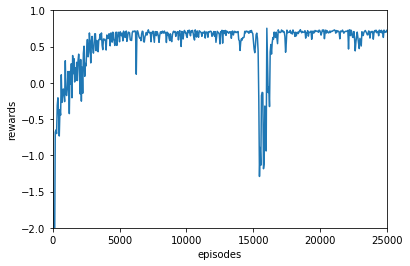

In [55]:
ppoAgent.plot_average_rewards(ylim=[-2,1])

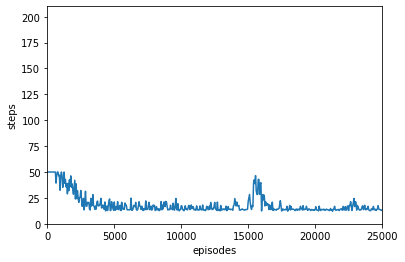

In [56]:
ppoAgent.plot_average_steps(ylim=[0,210])

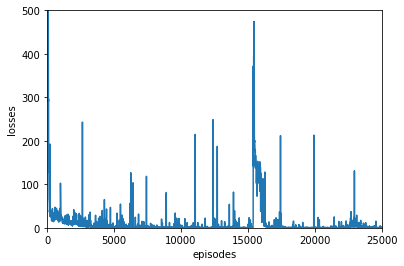

In [57]:
ppoAgent.plot_losses(ylim=[0,500])

In [58]:
from IPython.display import HTML

HTML( ppoAgent.render_episodes_to_html(num_episodes=1, fps=1) )


C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\olive\Anaconda3\envs\easyagents\lib\site-packages\ipykernel_launcher.py:250: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
W0723 17:02:46.169370 16748 ffmpeg.py:839] IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (648, 864) to (656, 864) to ensure video compatibility with most codecs and players. To prevent resizing, make you

<Figure size 864x648 with 0 Axes>